In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# from rich import print
import time 
# 全局取消证书验证
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from dataset import getDataLoader

In [3]:
def timeSince(since: float) -> str:
    s = time.time() - since
    return f"{int(s/60):2}m {int(s%60):02}s"

## 加载数据集并归一化增强

In [5]:
dataset_mean = np.array([0.4915, 0.4823, 0.4468])
dataset_std = np.array([0.2470, 0.2435, 0.2616])

transform = {
    'train': transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.9),
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize(dataset_mean, dataset_std)
     ]), 
    'test':  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
     ])
}
    

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True, 'batch_size':batch_size}

# trainset = CIFAR10(root='~/data', train=True, transform=transform['train'])
# K-Fold
train_dataset_index = [1, 2, 3, 4]
val_dataset_index = 5
# batch_size大小
train_batch_size = 512
val_batch_size = 512
test_batch_size = 512
trainloader = getDataLoader(train_dataIndex=train_dataset_index,
                             is_train_dataset=True,
                             batch_size=train_batch_size,
                             shuffle=True)
valloader = getDataLoader(train_dataIndex=val_dataset_index,
                           is_train_dataset=True,
                           batch_size=val_batch_size,
                           shuffle=False)
testloader = getDataLoader(is_train_dataset=False,
                            batch_size=test_batch_size,
                            shuffle=False)



 
#testset = CIFAR10(root='~/data', train=False, transform=transform['test'])
#testloader = DataLoader(testset, shuffle=False, **kwargs)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
# Defining the model
from coatnet import coatnet_0
from coatnet import coatnet_1
from coatnet import coatnet_2
from coatnet import coatnet_3
from coatnet import coatnet_4
from coatnet import coatnet_5

model = coatnet_0()
print(model(torch.randn(1,3,32,32,)).shape)

torch.Size([1, 10])


## 模型参数统计

In [8]:
from torchsummary import summary
summary(model.to(device), input_size=(3, 32, 32), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 64, 16, 16]           1,728
       BatchNorm2d-2          [512, 64, 16, 16]             128
              GELU-3          [512, 64, 16, 16]               0
            Conv2d-4          [512, 64, 16, 16]          36,864
       BatchNorm2d-5          [512, 64, 16, 16]             128
              GELU-6          [512, 64, 16, 16]               0
         MaxPool2d-7            [512, 64, 8, 8]               0
            Conv2d-8            [512, 96, 8, 8]           6,144
       BatchNorm2d-9          [512, 64, 16, 16]             128
           Conv2d-10           [512, 256, 8, 8]          16,384
      BatchNorm2d-11           [512, 256, 8, 8]             512
             GELU-12           [512, 256, 8, 8]               0
           Conv2d-13           [512, 256, 8, 8]           2,304
      BatchNorm2d-14           [512, 25

## 训练网络

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from datetime import datetime


def fwd_pass(net, loader, loss_function, optimizer, train=False):
    if train: net.train()
    else:     net.eval()

    total_loss = 0
    y_pred, y = [], []
    for _, X, labels in loader: #加载
        X, labels = X.to(device), labels.to(device)
        # ===================前=====================
        outputs = model(X)
        loss = loss_function(outputs, labels) 
        total_loss += loss.item()
        # ===================后====================
        if train:
            optimizer.zero_grad()# zero the parameter gradients
            loss.backward()
            optimizer.step()
        # ===============预测===============
        with torch.no_grad():
            y_hat = outputs.argmax(dim=1)
            y_pred.extend(y_hat.cpu().numpy().tolist())
            y.extend(labels.cpu().numpy().tolist())

    # =================return=====================
    with torch.no_grad():
        total_loss /= len(loader.dataset)
        acc = accuracy_score(y, y_pred)*100
        f1 = f1_score(y, y_pred, average="weighted")*100

    return total_loss, acc, f1




logs = dict( trainlosses=list(), testlosses=list(), 
            trainaccs=list(), testaccs=list() )
    

#训练
def train(model, train_loader, test_loader,
          optimizer, loss_function, epoch_num=1, device=device):
    model.to(device)
    torch.manual_seed(14)
    
    start = time.time()
    print(f"Training Process Starts at {datetime.now().strftime('%H:%M:%S')} ... ")
    
    epoch = 1
    test_acc1 = 0
    train_acc1 = 0
    times = 0
    # loop over the dataset multiple times
    
    while epoch<=epoch_num:
        # Training
        model = torch.load('./cifar10-1.h5')
        
        train_loss, train_acc, train_f1 = fwd_pass(model, trainloader, loss_function, 
                                                       optimizer, train=True)
            
        # Testing
        with torch.no_grad():
            test_loss, test_acc, test_f1 = fwd_pass(model, valloader, loss_function, 
                                                    optimizer, train=False)
        
        if test_acc-test_acc1 >=0:
            reset='\n' if epoch <= 5 or epoch%5==0 else '\r'
            print(f"Epoch[{epoch:2d}]>>>",
                f"Train/Test loss: {train_loss:.7f}/{test_loss:.7f},",
                f"Acc.: {train_acc:.2f}/{test_acc:.2f}",
                f"[[{timeSince(start)}]]", end=reset)
            
            # ===================log========================
            logs['trainlosses'].append(train_loss)
            logs['trainaccs'].append(train_acc)
            logs['testlosses'].append(test_loss)
            logs['testaccs'].append(test_acc)
            
            train_acc1=train_acc
            test_acc1=test_acc
            epoch += 1
            
            model_name = f'cifar10-1.h5'
            torch.save(model, model_name)
        else:
            times+=1
            if times>=100:
                break
            continue

    print(f'测试集F1: {test_f1}')
    print(f'Finished in {timeSince(start)}')
    return logs

In [10]:
model = coatnet_0()

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.Adam( model.parameters(), lr=learning_rate, weight_decay=1e-5,)

logs = train(model, train_loader=trainloader, test_loader=valloader,
             optimizer=optimizer, loss_function=criterion, 
             epoch_num=20)

Training Process Starts at 14:42:19 ... 
Epoch[ 1]>>> Train/Test loss: 0.0045417/0.0029356, Acc.: 33.49/45.83 [[ 0m 10s]]
Epoch[ 2]>>> Train/Test loss: 0.0024360/0.0023242, Acc.: 55.14/57.85 [[ 0m 20s]]
Epoch[ 3]>>> Train/Test loss: 0.0019319/0.0020901, Acc.: 65.03/63.70 [[ 0m 31s]]
Epoch[ 4]>>> Train/Test loss: 0.0014942/0.0019615, Acc.: 73.38/66.31 [[ 0m 42s]]
Epoch[ 5]>>> Train/Test loss: 0.0011707/0.0020659, Acc.: 78.88/66.55 [[ 0m 52s]]
Epoch[10]>>> Train/Test loss: 0.0002203/0.0030502, Acc.: 96.19/70.07 [[ 2m 26s]]
Epoch[15]>>> Train/Test loss: 0.0000907/0.0030668, Acc.: 98.58/72.93 [[ 8m 49s]]
Epoch[20]>>> Train/Test loss: 0.0000447/0.0032342, Acc.: 99.28/73.53 [ 36s]]
测试集F1: 73.63209567310618
Finished in 11m 36s


In [11]:
model_name = f'cifar10-1.h5'
torch.save(model, model_name)

#用保存了的模型继续跑
model = torch.load('./cifar10-1.h5')
learning_rate = 1e-3
logs = train(model, train_loader=trainloader, test_loader=valloader,
             optimizer=optimizer, loss_function=criterion, 
             epoch_num=10)

Training Process Starts at 14:53:56 ... 
Epoch[ 1]>>> Train/Test loss: 0.0000333/0.0032342, Acc.: 99.45/73.53 [[ 0m 10s]]
Epoch[ 2]>>> Train/Test loss: 0.0000317/0.0032342, Acc.: 99.46/73.53 [[ 0m 20s]]
Epoch[ 3]>>> Train/Test loss: 0.0000318/0.0032342, Acc.: 99.47/73.53 [[ 0m 31s]]
Epoch[ 4]>>> Train/Test loss: 0.0000311/0.0032342, Acc.: 99.48/73.53 [[ 0m 41s]]
Epoch[ 5]>>> Train/Test loss: 0.0000321/0.0032342, Acc.: 99.45/73.53 [[ 0m 52s]]
Epoch[10]>>> Train/Test loss: 0.0000316/0.0032342, Acc.: 99.46/73.53 [[ 1m 45s]]
测试集F1: 73.63209567310618
Finished in  1m 45s


In [12]:
model_name = f'cifar10.h5'
torch.save(model, model_name)

#用保存了的模型继续跑
model = torch.load('./cifar10.h5')
learning_rate = 1e-5
logs = train(model, train_loader=trainloader, test_loader=valloader,
             optimizer=optimizer, loss_function=criterion, 
             epoch_num=10)


Training Process Starts at 14:55:42 ... 
Epoch[ 1]>>> Train/Test loss: 0.0000333/0.0032342, Acc.: 99.45/73.53 [[ 0m 10s]]
Epoch[ 2]>>> Train/Test loss: 0.0000317/0.0032342, Acc.: 99.46/73.53 [[ 0m 20s]]
Epoch[ 3]>>> Train/Test loss: 0.0000318/0.0032342, Acc.: 99.47/73.53 [[ 0m 31s]]
Epoch[ 4]>>> Train/Test loss: 0.0000311/0.0032342, Acc.: 99.48/73.53 [[ 0m 41s]]
Epoch[ 5]>>> Train/Test loss: 0.0000321/0.0032342, Acc.: 99.45/73.53 [[ 0m 52s]]
Epoch[10]>>> Train/Test loss: 0.0000316/0.0032342, Acc.: 99.46/73.53 [[ 1m 45s]]
测试集F1: 73.63209567310618
Finished in  1m 45s


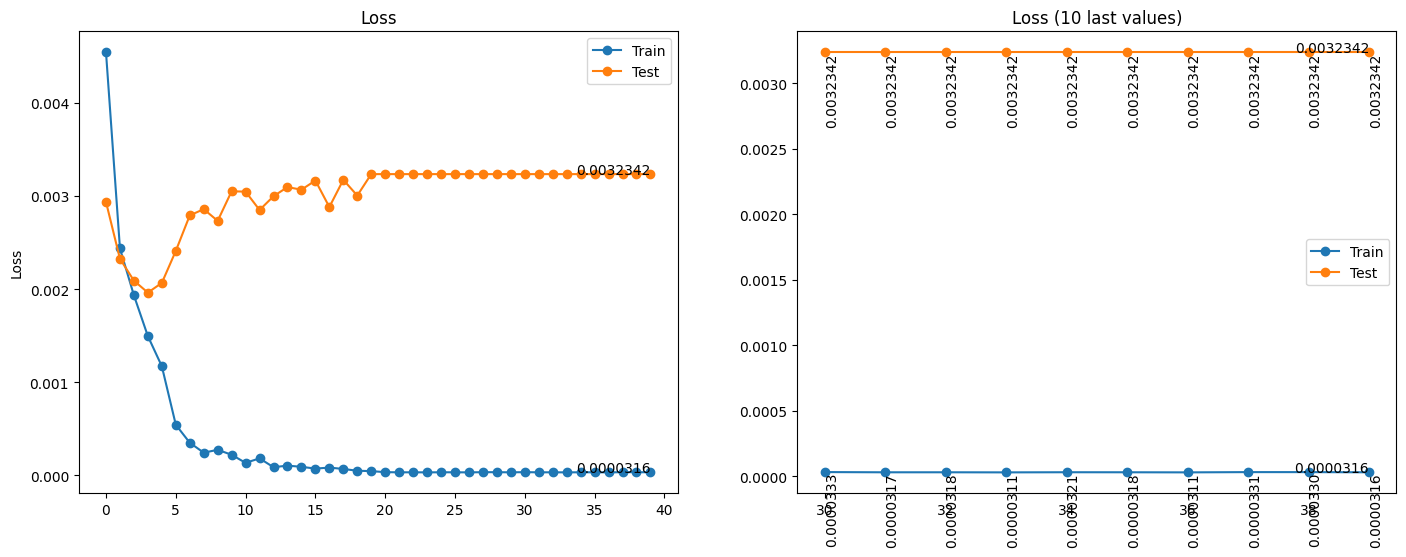

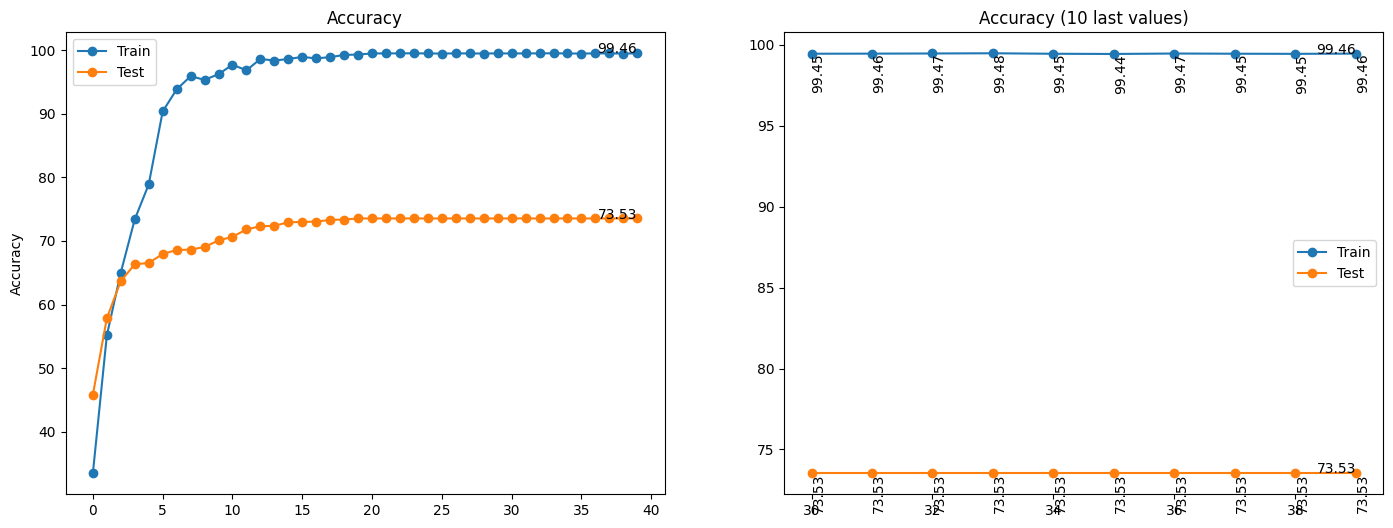

In [13]:
def res_plot(plotdata, xlabel='epoch', legend=['Train','Test'], title='Loss'):
    fig, axes = plt.subplots(1,2, figsize = (17,6))
    axes[0].set_ylabel(title)
    epochs = len(plotdata[0])-1
    for index, ax in enumerate(axes):
        n = 10 if index==1 else 0
        x = range(epochs-n+1, epochs+1) if index==1 else range(epochs+1)
        title = f"{title} ({n} last values)" if index==1 else title
#         ax.set_xlabel(xlabel)
        ax.set_title(title)
        ax.plot(x, plotdata[0][-n:], '-o', label=legend[0])
        ax.plot(x, plotdata[1][-n:], '-o', label=legend[1])
        p = 7 if 'loss'in title.lower() else 2
        if index==1:
            for i,j in list(zip(x,plotdata[1][-n:]))+list(zip(x, plotdata[0][-n:])):
                ax.annotate(f"{j:.{p}f}", xy=(i,j), rotation=90, va='top')
        ax.annotate(f"{plotdata[0][-1]:.{p}f}", xy=(len(plotdata[0])-1,plotdata[0][-1]),
                   ha="right")
        ax.annotate(f"{plotdata[1][-1]:.{p}f}", xy=(len(plotdata[1])-1,plotdata[1][-1]),
                   ha="right")
        ax.legend()

    plt.show()
    
res_plot((logs['trainlosses'], logs['testlosses']), title='Loss')
res_plot((logs['trainaccs'], logs['testaccs']), title='Accuracy' )

## 每类预测

In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_correct = [0.] * 10
class_total = [0.] * 10 
y_test, y_pred = [] , []
X_test = []

with torch.no_grad():
    for _X, images, labels in testloader:
        X_test.extend([_ for _ in images])
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i, label in enumerate(labels):
            class_correct[label] += c[i].item()
            class_total[label] += 1
        y_pred.extend(predicted.numpy())
        y_test.extend(labels.cpu().numpy())

for i in range(10):
    print(f"Acuracy of {classes[i]:5s}: {100*class_correct[i]/class_total[i]:2.0f}%")

Acuracy of plane: 76%
Acuracy of car  : 88%
Acuracy of bird : 59%
Acuracy of cat  : 63%
Acuracy of deer : 69%
Acuracy of dog  : 57%
Acuracy of frog : 78%
Acuracy of horse: 75%
Acuracy of ship : 80%
Acuracy of truck: 79%


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=classes)
print("Accuracy is :",ac) 
print(cr)

Accuracy is : 0.7237
              precision    recall  f1-score   support

       plane       0.75      0.76      0.76      1000
         car       0.79      0.88      0.83      1000
        bird       0.72      0.59      0.65      1000
         cat       0.51      0.63      0.57      1000
        deer       0.69      0.69      0.69      1000
         dog       0.61      0.57      0.59      1000
        frog       0.77      0.78      0.77      1000
       horse       0.79      0.75      0.77      1000
        ship       0.85      0.80      0.82      1000
       truck       0.80      0.79      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



### 混淆矩阵

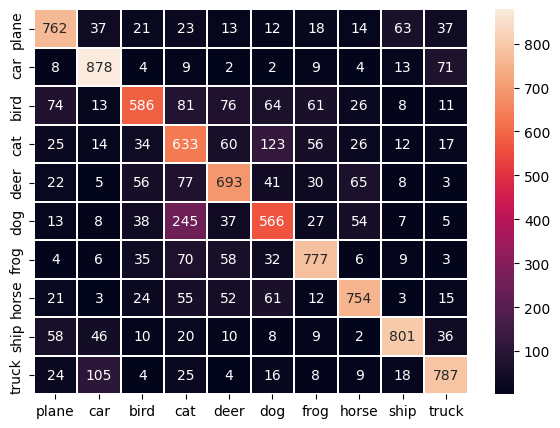

In [17]:
# 混淆矩阵

import seaborn as sns, pandas as pd

labels = pd.DataFrame(cm).applymap(lambda v: f"{v}" if v!=0 else f"")
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=labels, fmt='s', xticklabels=classes, yticklabels=classes, linewidths=0.1 )
plt.show()

## 保存模型

In [18]:
model_name = f'cifar10[1-78%].h5'
torch.save(model, model_name)
!cp {model_name} cifar10.h5
#!ls -sh cifar10.h5